In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

%matplotlib inline
sns.set(style='whitegrid')
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
def drop_columns(data):
    return data.drop(columns=['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])

data = yf.Ticker('MSFT')
df = drop_columns(data.history(start='2010-01-01'))
df.head()

,Close
Date,
2010-01-04,24.17
2010-01-05,24.18
2010-01-06,24.03
2010-01-07,23.78
2010-01-08,23.94


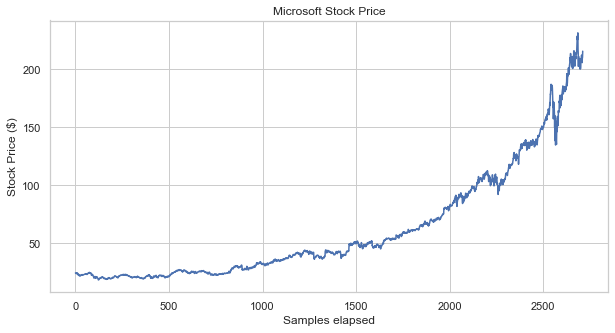

In [3]:
samples = np.arange(0, len(df), 1)
values = df['Close'].to_numpy()
plt.figure(figsize=(10,5))
plt.title('Microsoft Stock Price')
plt.plot(samples, values)
plt.xlabel('Samples elapsed')
plt.ylabel('Stock Price ($)')
plt.show()

In [4]:
df = pd.DataFrame(dict(price=values), index=samples, columns=['price'])

train_size = int(len(df)*0.7)
val_size = int(len(df)*0.2)
test_size = int(len(df)*0.1)

val_set = train_size + val_size
test_size = train_size + val_size + test_size
train, val, test = df.iloc[0:train_size], df.iloc[train_size:val_set], df.iloc[val_set:len(df)]
len(train), len(val), len(test)

(1898, 542, 272)

In [6]:
TIME_STEPS = 10

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i+time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train, train.price, TIME_STEPS)
X_val, y_val = create_dataset(val, val.price, TIME_STEPS)
X_test, y_test = create_dataset(test, test.price, TIME_STEPS)

def generate_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2])),
        tf.keras.layers.Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

model = generate_model()
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    verbose=1,
    shuffle=False,
    validation_data=(X_val, y_val)
)

Epoch 1/50
118/118 [==============================] - 1s 8ms/step - loss: 48.1697 - val_loss: 26.8916
Epoch 2/50
118/118 [==============================] - 1s 4ms/step - loss: 1.3290 - val_loss: 26.1395
Epoch 3/50
118/118 [==============================] - 1s 5ms/step - loss: 0.7645 - val_loss: 9.6507
Epoch 4/50
118/118 [==============================] - 1s 5ms/step - loss: 1.0771 - val_loss: 23.3251
Epoch 5/50
118/118 [==============================] - 1s 5ms/step - loss: 1.0100 - val_loss: 26.4859
Epoch 6/50
118/118 [==============================] - 1s 5ms/step - loss: 0.9214 - val_loss: 16.6410
Epoch 7/50
118/118 [==============================] - 1s 5ms/step - loss: 0.9775 - val_loss: 8.6319
Epoch 8/50
118/118 [==============================] - 1s 5ms/step - loss: 0.9857 - val_loss: 21.0684
Epoch 9/50
118/118 [==============================] - 1s 5ms/step - loss: 0.8954 - val_loss: 23.6091
Epoch 10/50
118/118 [==============================] - 1s 5ms/step - loss: 0.8475 - val_loss

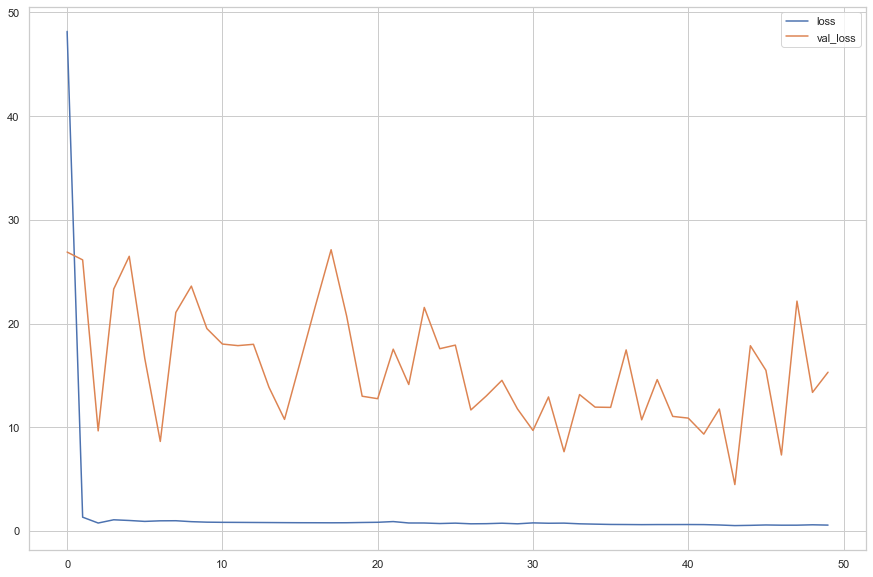

In [7]:
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

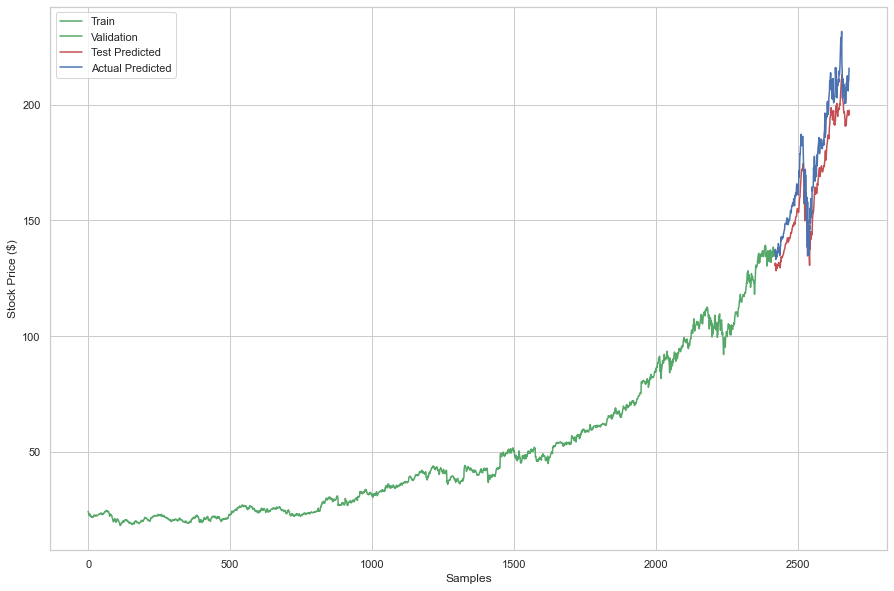

In [9]:
y_pred = model.predict(X_test)
plt.figure(figsize=(15,10))
plt.plot(np.arange(0, len(y_train)), y_train, 'g')
plt.plot(np.arange(len(y_train), (len(y_train)+len(y_val))), y_val, 'g')
plt.plot(np.arange((len(y_train)+len(y_val)), (len(y_train)+len(y_val)+len(y_test))), y_pred, 'r')
plt.plot(np.arange((len(y_train)+len(y_val)), (len(y_train)+len(y_val)+len(y_test))), y_test, 'b')
plt.xlabel('Samples')
plt.ylabel('Stock Price ($)')
plt.legend(['Train', 'Validation', 'Test Predicted', 'Actual Predicted'])
plt.savefig('Bidirectional LSTM Example.png')
plt.show()